# Data Augmentation

В данном ноутбуке мы с вами ознакомимся с идеей аугментации данных и покажем на примере фреймворка TensorFlow и Keras, как выполнять данную аугментацию.

Внимание! Данный ноутбук требует tensorflow версии 2.7.0 и любого из Python 3.7-3.9. Указанная ниже команда установит фреймворк нужной версии и удалит все предыдущие. Если вы не хотите удалять текущую установленную версию библиотеки или версия вашего интерпретатора не соответствует нужной, вы можете выполнить данный ноутбук на Google Colab. 

In [1]:
!pip install tensorflow==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 665.5 MB 22 kB/s 
     |████████████████████████████████| 1.3 MB 7.9 MB/s 
     |████████████████████████████████| 463 kB 61.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.2
    Uninstalling tensorflow-2.9.2:
      Successfully uninstalled tensorflow-2.9.2


Импортируем и проверяем.

In [ ]:
import tensorflow as tf
assert tf.__version__ == "2.7.0"

Импортируем все необходимые библиотеки и установим размер изображений в ноутбуке побольше.

In [ ]:
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import layers

plt.rcParams['figure.figsize'] = [12, 8]

В качестве набора данных давайте будем использовать датасет TensorFlow Flowers - набор изображений цветов. Скачаем и разделим его на два набора.

In [ ]:
train_ds, test_ds = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to ~/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


Давайте возьмем первое изображение из набора и посмотрим на него.

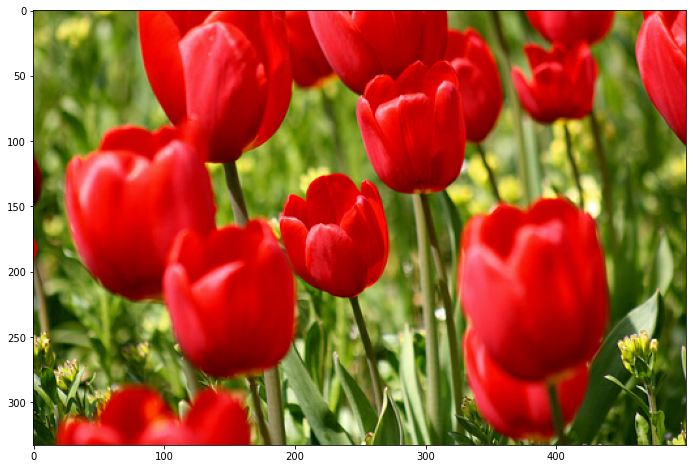

In [ ]:
image, label = next(iter(train_ds))
plt.imshow(image)

Итак, что же такое аугментация данных и зачем она нужна?  

В общем случае, аугментация данных — это изменение характеристик данных для достижения каких-либо целей в процессе обучения. Мы с вами сейчас будем говорить об аугментации изображений, но в общем случае это применимо к любому типу данных.

В процессе тренировки нейронная сеть старается найти наиболее простые пути предсказания верных ответов для заданного набора данных. Чаще всего наборы данных изображений созданы в примерно одинаковых условиях, с поставленным светом или при одинаковых настройках фототехники. Таким образом, если все фотографии были достаточно яркие, сеть может плохо оценивать фото с низким уровнем освещенности, так как оно не было представлено в тренировочном наборе данных, или уметь распознавать объект только если он занимает определенную часть изображения (не более четверти, например). Кроме того, можно вспомнить, что сверточные сети (благодаря принципу построения) являются трансляционно инвариативными (т.е. могут находить объект вне зависимости от расположения), но не инвариативны к размеру объекта, углу наклона, и так далее.

Для того чтобы «познакомить» сеть с тем, что некоторые характеристики фотографий и объектов (размер, освещенность, угол наклона, и т.д.) меняются, используют _аугментацию изображений_. Аугментация изображений — это (чаще всего) случайные изменения некоторых параметров изображения, которые заставляют сеть понимать, что класс объекта не меняется от, например, освещенности и наклона. Аугментация изображений делает сеть более стабильной, ее также можно рассматривать как «виртуальное» увеличение размера набора данных за счет создания аугментированных изображений. Некоторые библиотеки аугментации изображений даже добавляют сложные эффекты, такие как дождь или туман, генерируя их по определенному паттерну. Мы очень рекомендуем вам обратить внимание на библиотеку Albumentations, если вам понадобится использовать аугментации изображений в процессе обучения ваших моделей.

В данном примере мы будем пользоваться встроенными функциями TensorFlow.

## Layers

В список слоев Keras входят несколько слоев для базовой предобработки изображений, например, для изменения размера и нормализации изображения. Эти слои можно интегрировать в вашу модель нейронной сети в качестве начальных слоев для автоматической обработки изображений.

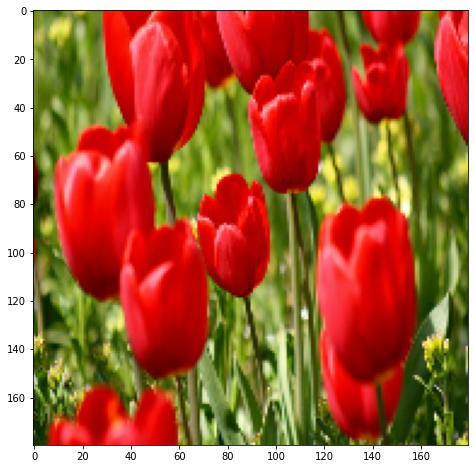

In [ ]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

result = resize_and_rescale(image)
plt.imshow(result)

Кроме того, в списке слоев Keras также существуют достаточно полезные слои RandomFlip и RandomRotation, которые позволяют случайным образом перевернуть или повернуть изображение на случайный угол.

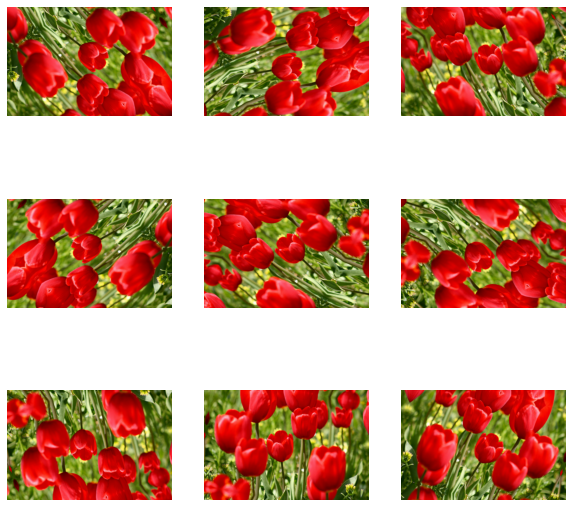

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

image = tf.expand_dims(image, 0)
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")


Вы можете использовать полученный Sequential объекты двумя способами.

1. Как мы уже упомянули ранее, вы можете напрямую встроить эти объекты в вашу модель нейронной сети и использовать в процессе обучения. Данные трансформации будут применяться в процессе обучения случайным образом для каждого изображения во время каждой эпохи. Кроме того, достаточно важным фактором является то, что при наличии графического ускорителя данные слои могут полноценно его использовать.

In [ ]:
model = tf.keras.Sequential([
  # Слои предобработки
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),
  # ... остальная часть модели
])


2. Вы можете подать их в функцию `.map` для применения на этапе получения изображения из набора данных.

In [ ]:
aug_ds = test_ds.map(lambda x, y: (resize_and_rescale(x, training=True), y))

Также при желании вы можете реализовать собственный слой аугментации данных. Для этого вы можете использовать Lambda слой, позволяющий реализовать любую функцию, и обернуть ее в слой для возможности применения в нейронной сети.

In [ ]:
def random_invert_img(x, p=0.5):
    return (255 - x) if tf.random.uniform([]) < p else x

random_invert = layers.Lambda(lambda x: random_invert_img(x, 0.5))

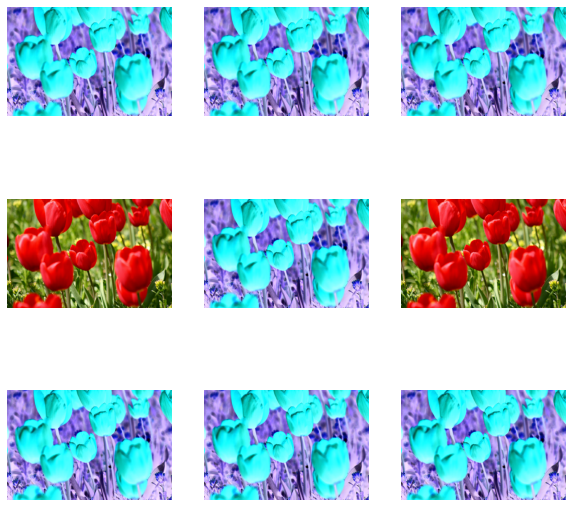

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = random_invert(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")


## tf.image

В случае работы с стандартными RGB изображения, в фреймворке tensorflow присутствует модуль `tf.image`, содержащий в себе различные методы работы с изображениями. Давайте продемонстрируем некоторые из них. Для этого создадим функцию, которая будет показывать оригинальное и аугментированное изображение рядом.

In [ ]:
def visualize(original, augmented):
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)
    
    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)

image, label = next(iter(train_ds))

В модуле `tf.image` представлены различные функции, например, переворота изображения.

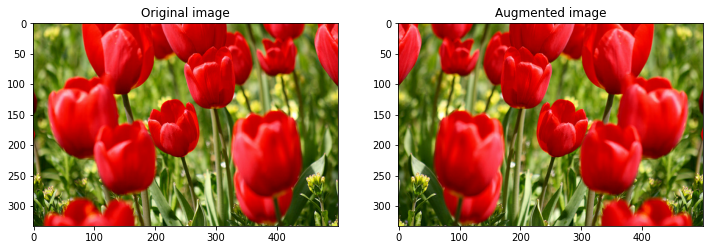

In [ ]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

Или представление изображения в оттенках серого.

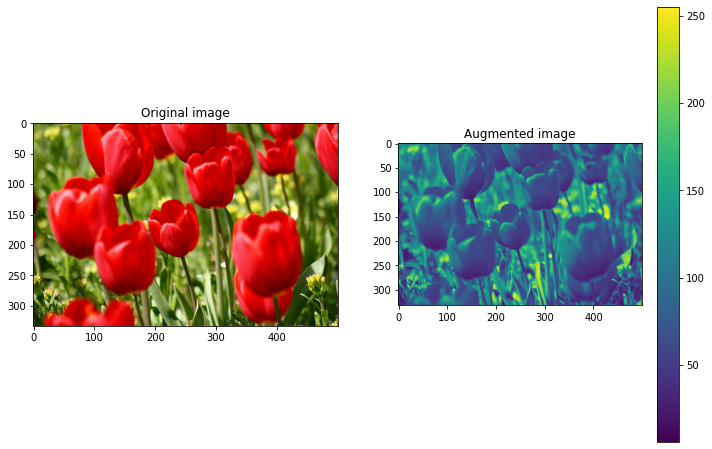

In [ ]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
plt.colorbar()

Изменение насыщенности изображения.

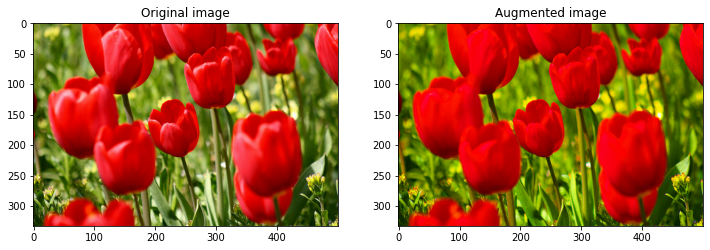

In [ ]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

Изменение яркости изображения

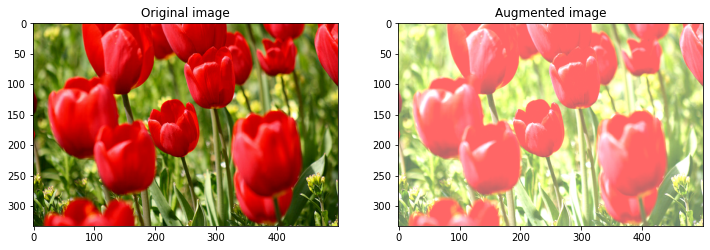

In [ ]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

Кроме того, присутствует функция `central_crop` - вырезания части изображения с фокусом на центре.

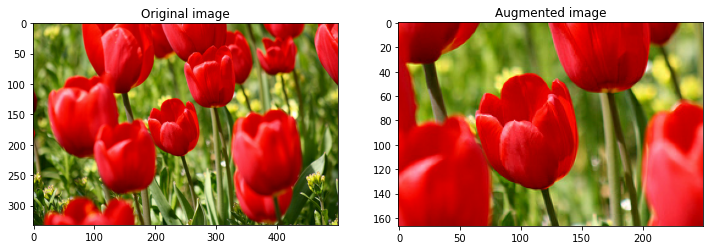

In [ ]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

Поворот изображения

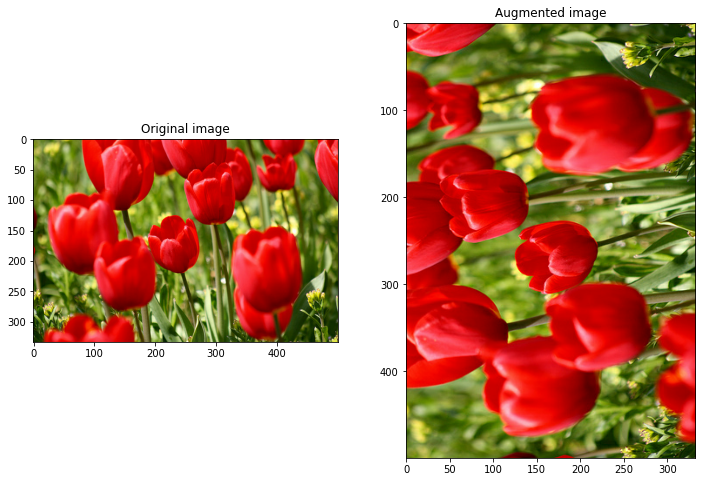

In [ ]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

## tf.image.stateless_random_*

Наиболее полезными в процессе обучения оказываются методы, выполняющие случайные преобразования изображений. Данные методы расположены в модуле `tf.image` и все начинаются с префикса `stateless_random_`. Префикс `stateless` означает то, что кроме самого изображения, методу необходимо подать seed для случайного генератора (тензор из 2х float элементов), при этом для одинаковых seed'ов результаты случайного преобразования будут одинаковы.

Давайте продемонстрируем это на примере функции `stateless_random_brightness`.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


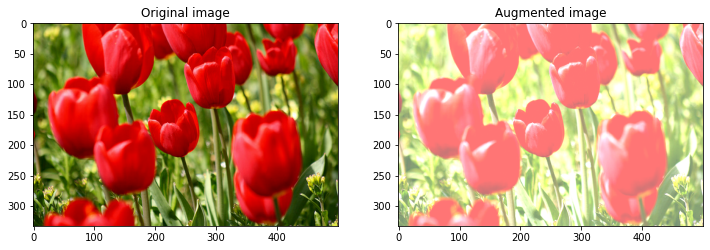

In [ ]:
for i in range(3):
    seed = (i, i)  # кортеж размера (2,)
    stateless_random_brightness = tf.image.stateless_random_brightness(image, max_delta=0.5, seed=seed)
    visualize(image, stateless_random_brightness)

Как можно заметить, к изображению были применены случайные изменения яркости. При этом при перезапуске ячейке вы получите те же самые результаты в связи с одинаковыми значениями random seed, подаваемыми в функцию.  

Аналогичным образом используется `stateless_random_contrast`.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


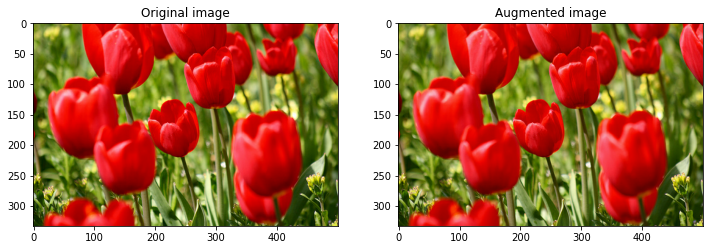

In [ ]:
for i in range(3):
    seed = (i, i)
    stateless_random_contrast = tf.image.stateless_random_contrast(
        image, lower=0.3, upper=1.0, seed=seed)
    visualize(image, stateless_random_contrast)

Очень полезной функцией, достаточно часто применяемой в аугментации изображений, является `random_crop` - случайно вырезанный кадр изображения. Стоит отметить, что в некоторых случаях данная функция неприменима, т.к. может выдать часть изображения без нужных объектов - стоит это учитывать в процессе планирования применения данной аугментации.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


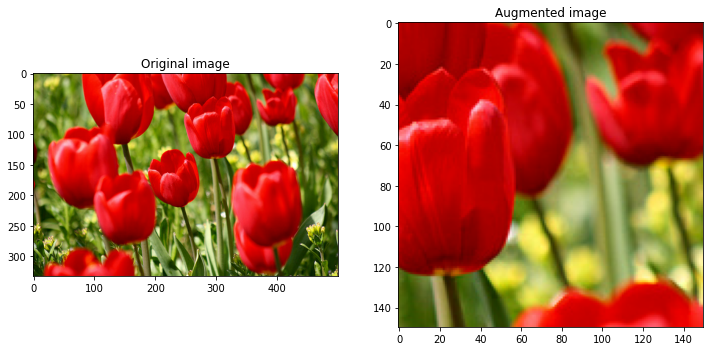

In [ ]:
for i in range(3):
    seed = (i, i)
    stateless_random_crop = tf.image.stateless_random_crop(
        image, size=[150, 150, 3], seed=seed)
    visualize(image, stateless_random_crop)

Список наиболее часто применяемых функций следующий:
```
tf.image.stateless_random_brightness
tf.image.stateless_random_contrast
tf.image.stateless_random_crop
tf.image.stateless_random_flip_left_right
tf.image.stateless_random_flip_up_down
tf.image.stateless_random_hue
tf.image.stateless_random_jpeg_quality
tf.image.stateless_random_saturation
```   

В процессе предобработки изображения вам понадобится генератор случайных чисел для данных функций. Чаще всего его реализуют следующим образом:

In [ ]:
# создаем объект-генератор
rng = tf.random.Generator.from_seed(123)

# опционально - создаем функцию-обертку для упрощенной работы
rng_new_seed = lambda: rng.make_seeds(2)[0]

## Пример работы

Давайте построим пример пайплайна для предобработки изображений для нейронной сети. 
Т.к. мы будем использовать сверточную сеть для условной задачи классификации, все изображения необходимо будет привести к единому размеру, преобразовать из `tf.uint8` в `tf.float32` и разделить на 255 (чтобы нормализовать к отрезку [0, 1]).
Создадим функцию для данных преобразований.

In [ ]:
DESIRED_IMAGE_SHAPE = (240, 320)

def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, DESIRED_IMAGE_SHAPE)
    image = (image / 255.0)
    return image, label

Далее создадим функцию для аугментации. Данная функция будет использовать `resize_and_rescale` для необходимых операций, а затем применять случайные аугментации - вырезать часть изображения, менять яркость и зеркалировать.

In [ ]:
CROP_SHAPE = (180, 240, 3)

def augment(image, label):
    image, label = resize_and_rescale(image, label)   

    # Random crop
    image = tf.image.stateless_random_crop(image, size=CROP_SHAPE, seed=rng_new_seed())
    
    # Random brightness
    image = tf.image.stateless_random_brightness(image, max_delta=0.2, seed=rng_new_seed())
    
    # Добавляем clip для гарантии того, что значения не вышли за пределы
    # в процессе изменения яркости
    image = tf.clip_by_value(image, 0, 1)
    
    # random flips
    image = tf.image.stateless_random_flip_left_right(image, seed=rng_new_seed())
    return image, label

Давайте посмотрим на результат применения этих аугментаций. Позапускайте следующую ячейку несколько раз, чтобы убедиться, что трансформации случайны.

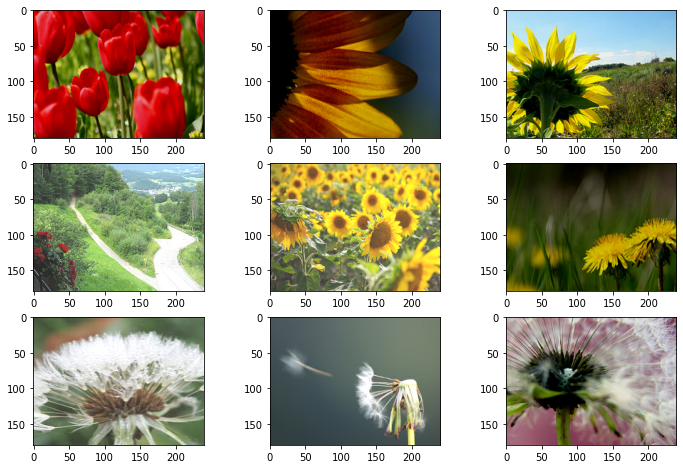

In [ ]:
new_train_ds = train_ds.map(augment)

fig, axarr = plt.subplots(3, 3)
for i, (image, label) in enumerate(new_train_ds.take(9)):
    axarr[i // 3, i % 3].imshow(image)


---

Мы с вами рассмотрели основы аугментации изображений с помощью функций, встроенных в фреймворк TensorFlow. Как мы уже упоминали, аугментации являются очень полезным инструментом в процессе обучения сверточных сетей, работающих с изображениями, и мы рекомендуем их использовать, как встроенный в фреймворк, так и реализованные в отдельных библиотеках.

Успехов в дальнейшем обучении!
